# Import Libraries

In [3]:
# Scientific libraries

import numpy as np
import math

# Visualization Libraries

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Data analysis and ML libraries

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split


# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.feature_selection import SelectKBest, chi2, f_classif

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss,TomekLinks
from imblearn.combine import SMOTETomek

###
#from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline

###
from functions import my_scaler, evaluate_model

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Import cleaned data

In [5]:
df = pd.read_csv('Data/diabetes_renamed.csv')

In [19]:
#df = df[( (df["BMI"] < 44) & (df["BMI"] > 15))]
#df = df[( (df["Physical_health"] < 15))]
#df = df[( (df["Mental_health"] < 15))]

# Split

In [7]:
target = "Diabetes_status"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (181192, 21)
y shape: (181192,)


In [8]:
#Train-test split. We have set random_state=42 for reproducibility

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

- We have to scale our data before performing any fit.
- We use the function my_scaler, which transforms only the non-binary features of the data set.
- The non-binary (ordinal) features are: BMI, general health, physical health, mental health, age and income


In [9]:
# Scaled sets.
# We will perform outfits with this scaled data

X_train_scaled = my_scaler(X_train,StandardScaler())
X_test_scaled = my_scaler(X_test,StandardScaler())

# Build Model

In [10]:
target_count = y_train.value_counts(normalize=True)
acc_baseline = target_count.max()

### Baseline: train the model without resampling/balancing the data

In this case, we want to build a diabetes predictor. Therefore we need to minimize the numbers of false positives in our model

- Therefore we need to minimize the numbers of false positives in our model
- We want a recall as close to 1 as possible
- We want an F1-score of at least 0.5

In [11]:
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.87


Classification report for training data
              precision    recall  f1-score   support

           0       0.88      0.99      0.93    126403
           1       0.53      0.10      0.17     18550

    accuracy                           0.87    144953
   macro avg       0.71      0.54      0.55    144953
weighted avg       0.84      0.87      0.83    144953

Classification report for test data
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     31602
           1       0.50      0.10      0.17      4637

    accuracy                           0.87     36239
   macro avg       0.69      0.54      0.55     36239
weighted avg       0.83      0.87      0.83     36239

Confusion matrix for test set
The optimal threshold is: 0.13355950632215585
The false positive rate at the opt threshold: 0.2791911904309854
The true positive rate at the opt threshold: 0.7442311839551434


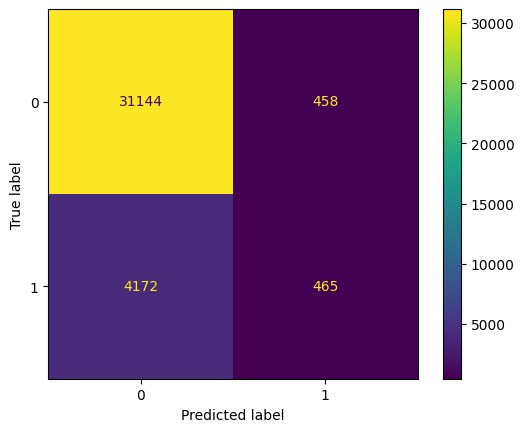

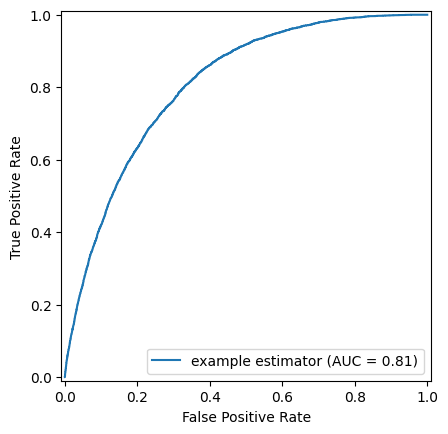

In [12]:
## Build model

LR = LogisticRegression(max_iter=1000)
evaluate_model(LR, X_train_scaled, y_train, X_test_scaled, y_test)


REMARKS:

- Accuracy: same as baseline for both training and test sets
- Recall: Very low -> only 15 % of positives in the test set are correctly identified by the model
- F1: Very low as well
- Good AUC: The model has decent discriminative ability -> The model can distinguish between classes relatively well when changing the classification threshold.
- **Next**: Try changing the threshold or balancing the classes (analogous to resampling)

## Iterate and evaluate

### Train the model imposing a balanced class_weight!

#### Balanced Logistic Regression

Classification report for training data
              precision    recall  f1-score   support

           0       0.95      0.71      0.81    126403
           1       0.28      0.76      0.40     18550

    accuracy                           0.72    144953
   macro avg       0.61      0.73      0.61    144953
weighted avg       0.87      0.72      0.76    144953

Classification report for test data
              precision    recall  f1-score   support

           0       0.95      0.71      0.81     31602
           1       0.28      0.75      0.40      4637

    accuracy                           0.71     36239
   macro avg       0.61      0.73      0.61     36239
weighted avg       0.87      0.71      0.76     36239

Confusion matrix for test set
The optimal threshold is: 0.5123495742269693
The false positive rate at the opt threshold: 0.27840010125941395
The true positive rate at the opt threshold: 0.7440155272805693


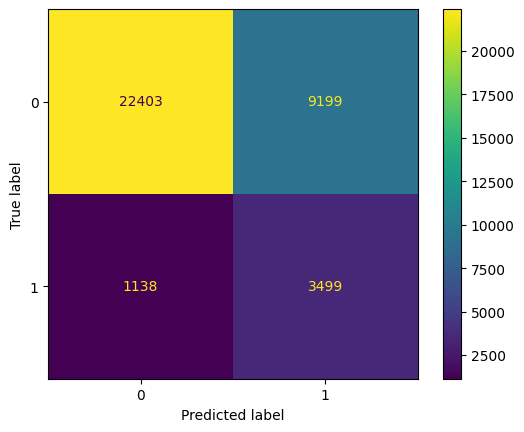

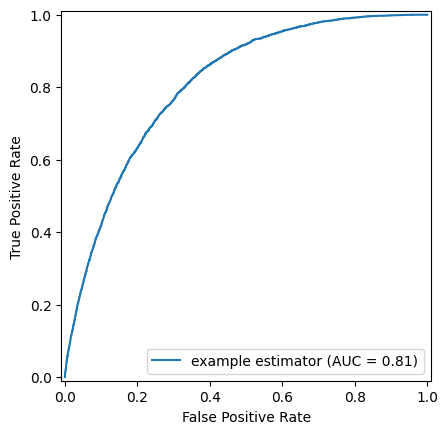

In [13]:
## Build model
LR_balanced = LogisticRegression(max_iter=100,class_weight='balanced')
evaluate_model(LR_balanced, X_train_scaled, y_train, X_test_scaled, y_test)

REMARKS:

- Accuracy: Lower than baseline model. This is expected since now we get a better recall
- Recall: Good -> 76 % of positives in the test set are correctly identified by the model
- F1: Still on the lower side.
- AUC: still is ~0.8 -> Model can be improved changing the threshold
- In general, the model is struggling to correctly identify positives and negatives

In [14]:
LR_balanced_importances = LR_balanced.coef_[0]

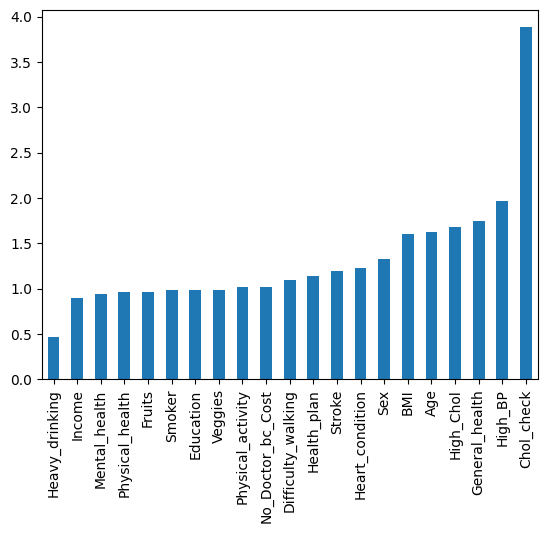

In [15]:
feat_imp = pd.Series(np.exp(LR_balanced_importances), index=X_train.columns).sort_values()
feat_imp.plot(kind="bar");

#### Train and evaluate a Random Forest

Classification report for training data
              precision    recall  f1-score   support

           0       0.96      0.72      0.82    126403
           1       0.29      0.79      0.42     18550

    accuracy                           0.73    144953
   macro avg       0.62      0.75      0.62    144953
weighted avg       0.87      0.73      0.77    144953

Classification report for test data
              precision    recall  f1-score   support

           0       0.95      0.71      0.81     31602
           1       0.28      0.75      0.40      4637

    accuracy                           0.72     36239
   macro avg       0.61      0.73      0.61     36239
weighted avg       0.86      0.72      0.76     36239

Confusion matrix for test set
The optimal threshold is: 0.5028532102422357
The false positive rate at the opt threshold: 0.28558319093728246
The true positive rate at the opt threshold: 0.7476816907483287


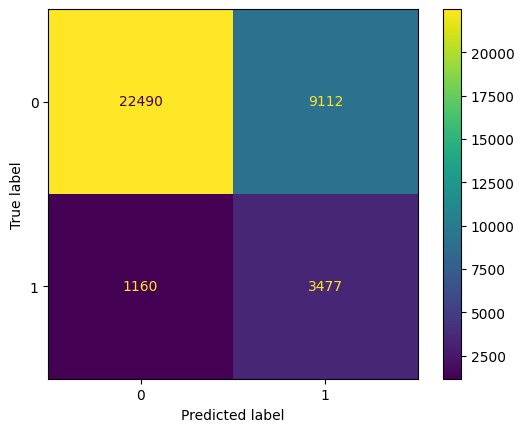

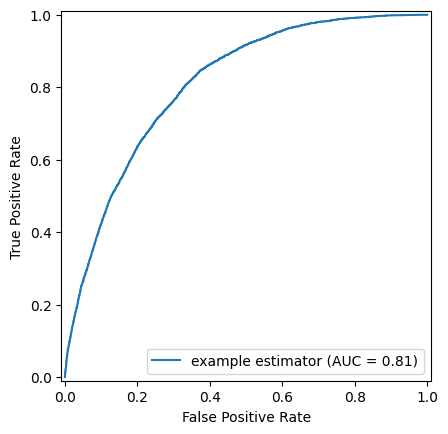

In [16]:
RF = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=42,class_weight='balanced')
evaluate_model(RF,X_train_scaled, y_train, X_test_scaled, y_test)

In [17]:
#RF_importances  = RF.feature_importances_
rf_scores = pd.DataFrame({
    'feature': X_train.columns,
    'RF_Importance': RF.feature_importances_
}).sort_values(by=['RF_Importance'])

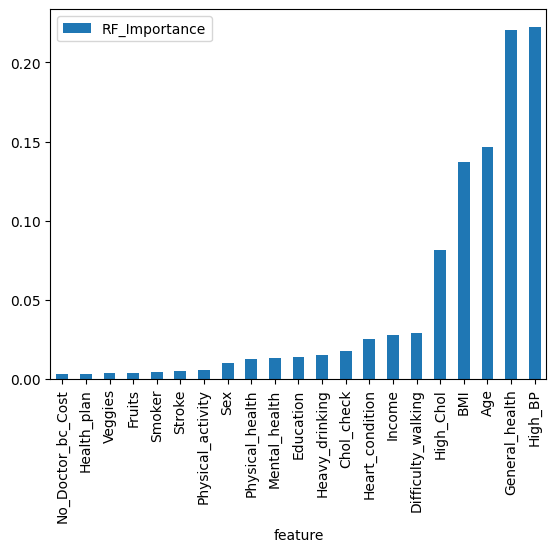

In [18]:
rf_scores.plot(kind="bar", x='feature');

### REMARKS:

- Both models, the balanced logistic regression and the balanced Random Forest, perform very similar
- Since we are dealing with a diabetes classification task, the false negatives are expensive (our customer can be an insurance company or a hospital) 
- Goal: Keep the recall of this order but improve F1
- **NEXT**: We do some feature selection to simplify our model